### Dependencies

In [1]:
import sys, os
from csv import DictWriter

import numpy as np
import pandas as pd
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

from itertools import combinations_with_replacement
from itertools import chain

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['text.usetex'] = False
from result_utils import *
from manual_sindy import *
from gendata import *   



#### Random seed

In [2]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

### Parameters dataclass

In [3]:
@dataclass
class parameters:
    # Learning hyperparameters
    num_epochs = 1000
    num_iter = 3
    lr = 1e-1
    weightdecay = 0.0
    tol_coeffs: float = 1e-1
    scaling: bool = True

    m1: float = 1.0
    m2: float = 1.0
    c1: float = 0.1
    c2: float = 0.1
    k1: float = 1.0
    k2: float = 1.0
    freq1: float = 0.6
    freq2: float = 0.0
    F1: float = 1.0
    F2: float = 0.0
    phi: float = 0.0
   
    timestep: float = 1e-2
    timefinal: float = 50.0

    x0: tuple = (0.0, 0.0, 0.0, 0.0)
    save_analysis = False 
    
    n_eqs: int = 2
    
    # Assumed features
    poly_order: int = 1
    # cos_phases: np.ndarray = np.arange(0.9, 1.51, 0.3)
    cos_phases: np.ndarray = ()
    y1_sgn_flag: bool = False
    y2_sgn_flag: bool = False
    log_1_fr1: bool = False
    log_2_fr1: bool = False
    log_1_fr2: bool = False
    log_2_fr2: bool = False

    noisy_measure_flag: bool = True
    noise_level: float = 1e-1
    
Params = parameters()

Params.fr1: dict = {'DR_flag' : False, 'friction_force_ratio' : 0.0, 'a': 0.07, 'b': 0.09, 'c': 0.022, 'V_star': 0.003, 'eps': 1e-6}
Params.fr2: dict = {'DR_flag' : False, 'friction_force_ratio' : 0.5, 'a': 0.07, 'b': 0.09, 'c': 0.022, 'V_star': 0.003, 'eps': 1e-6}


In [4]:
ts, x_denoised = generate_data(Params)

#Generate noisy measurements
if Params.noisy_measure_flag:
    x = np.random.normal(loc=x_denoised, scale=Params.noise_level * np.abs(x_denoised), size=x_denoised.shape)
else:
    x = x_denoised

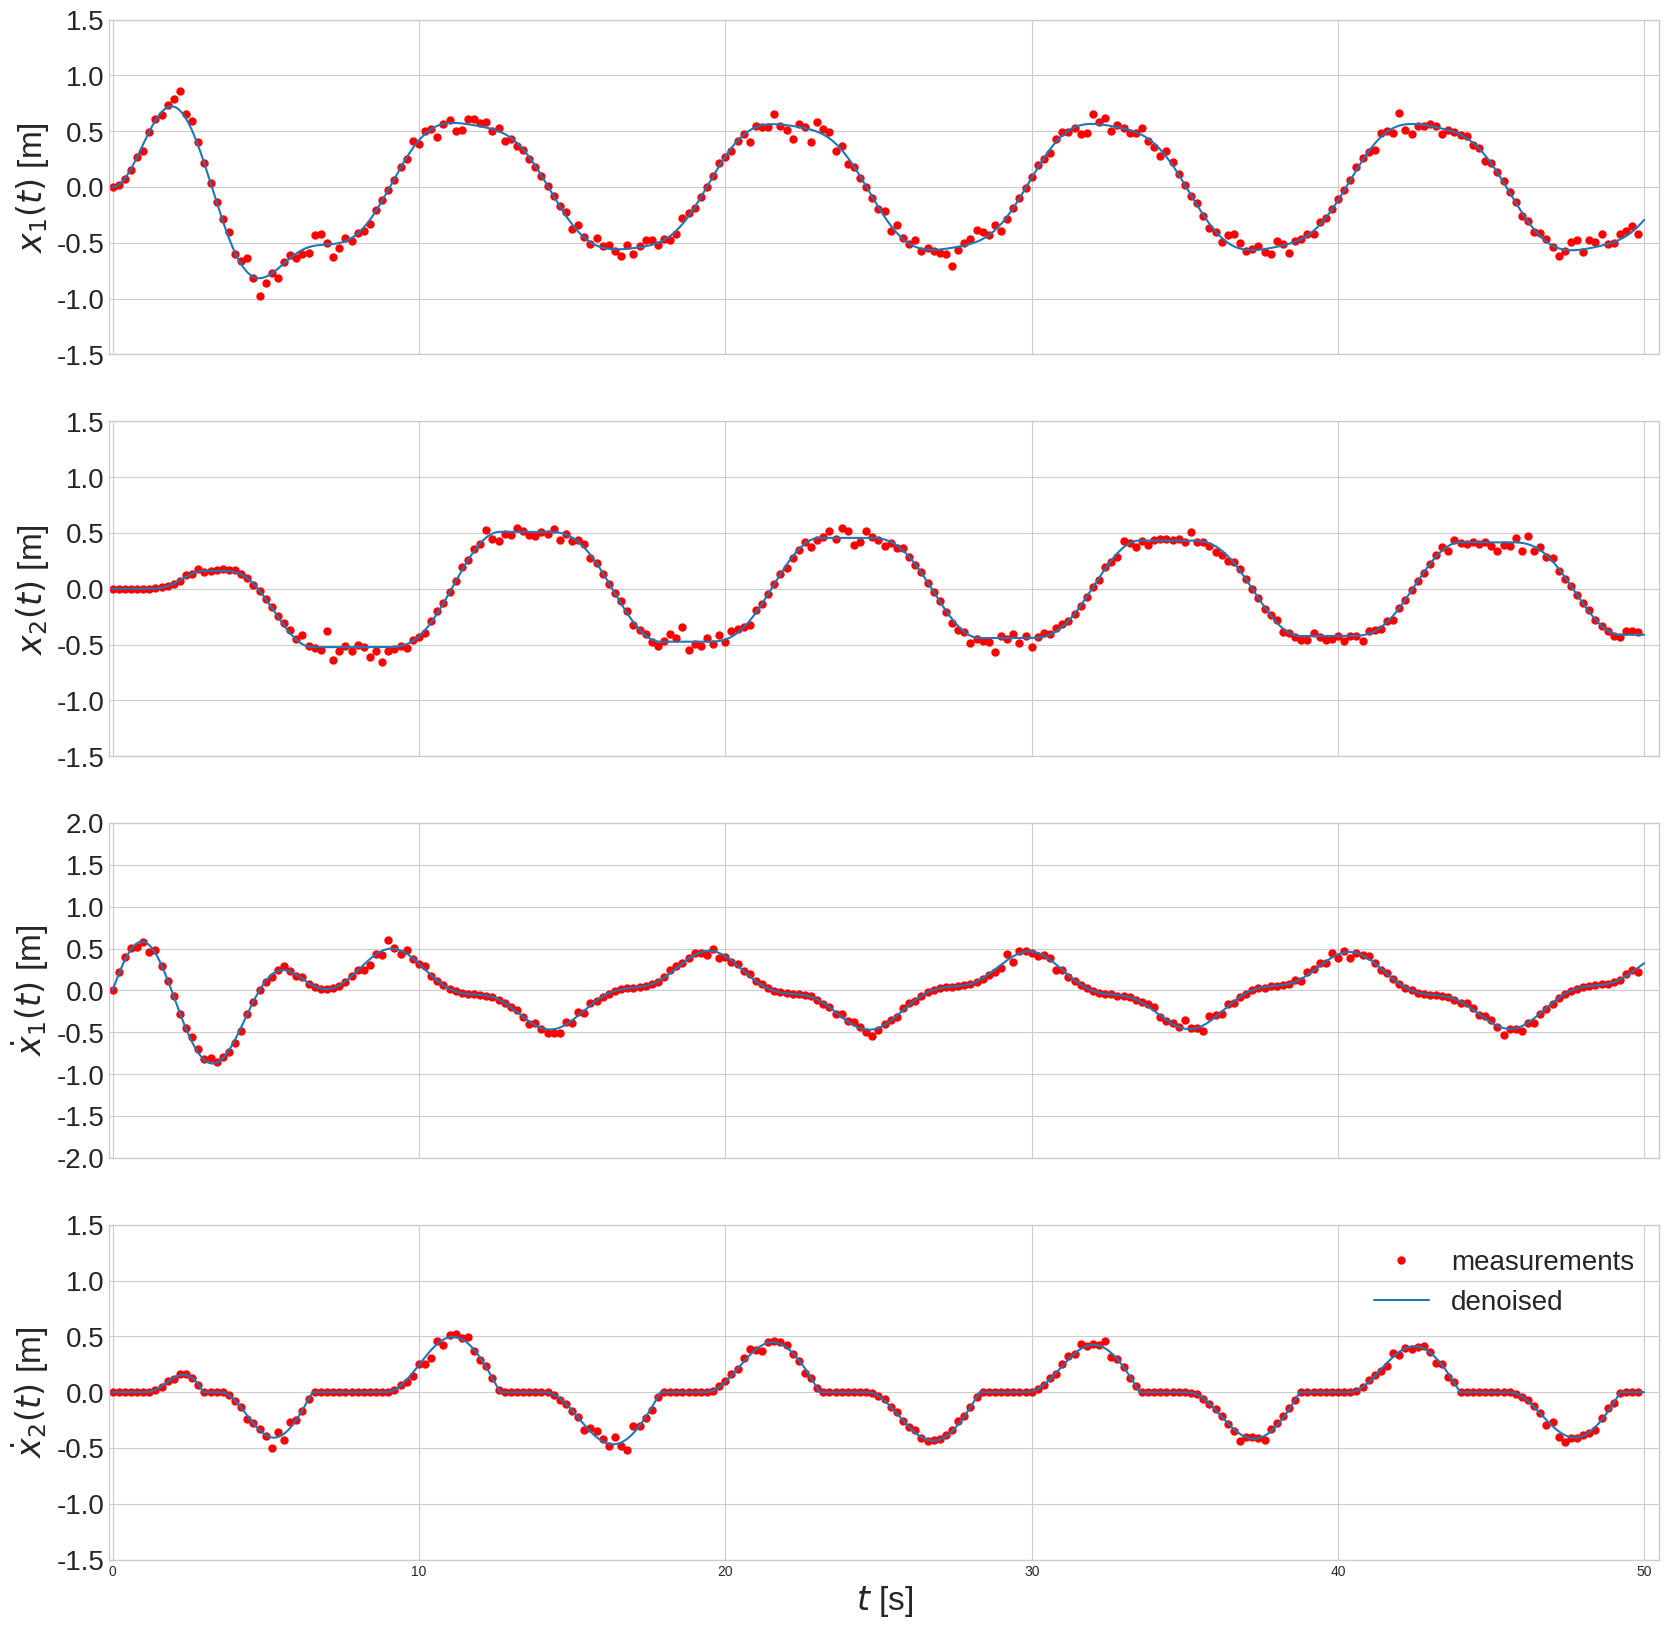

In [5]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(20,20), sharex=True)
ax1.plot(ts[::20], x[::20, 0],"ro", markersize=5, label='measurements')
ax2.plot(ts[::20], x[::20, 1],"ro", markersize=5, label='measurements')
ax1.plot(ts, x_denoised[:, 0], label='denoised')
ax2.plot(ts, x_denoised[:, 1], label='denoised')
ax3.plot(ts[::20], x[::20, 2],"ro", markersize=5, label='measurements')
ax4.plot(ts[::20], x[::20, 3],"ro", markersize=5, label='measurements')
ax3.plot(ts, x_denoised[:, 2], label='denoised')
ax4.plot(ts, x_denoised[:, 3], label='denoised')

plt.xlabel(r"$t$ [s]", fontsize=24)
ax1.set_ylabel(r"$x_1(t)$ [m]", fontsize=24)
ax2.set_ylabel(r"$x_2(t)$ [m]", fontsize=24)
ax3.set_ylabel(r"$\dot{x}_1(t)$ [m]", fontsize=24)
ax4.set_ylabel(r"$\dot{x}_2(t)$ [m]", fontsize=24)

ax1.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)
ax1.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)
ax2.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)
ax2.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)
ax3.set_yticks(np.arange(-2.0, 2.1, 0.5), np.arange(-2.0, 2.1, 0.5), fontsize=20)
ax3.set_yticks(np.arange(-2.0, 2.1, 0.5), np.arange(-2.0, 2.1, 0.5), fontsize=20)
ax4.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)
ax4.set_yticks(np.arange(-1.5, 1.6, 0.5), np.arange(-1.5, 1.6, 0.5), fontsize=20)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax3.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 

plt.legend(fontsize=20)
ax1.set_xlim((-0.1, 1.01 * ts[-1]))
ax2.set_xlim((-0.1, 1.01 * ts[-1]))
plt.show()

### Learn sparse solution



In [ ]:
if Params.scaling:
    Params.mus = T.tensor(np.mean(x, axis=0)).float().unsqueeze(0)
    Params.stds = T.tensor(np.std(x, axis=0)).float().unsqueeze(0)

# Learn the coefficients
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

no_of_terms = apply_features(train_dset[:2], times[:2], params=Params).shape[1]

coeffs = CoeffsDictionary(no_of_terms, Params.n_eqs)

# Learning Coefficients
coeffs, loss_track = learn_sparse_model(coeffs, train_dset, times, Params, lr_reduction=10)

# TODO: how to interpret this coefficients
learnt_coeffs = coeffs.linear.weight.detach().clone().t().numpy()

print()
print(learnt_coeffs)
# equation = print_learnt_equation(lrcfs, Params)

# print(f"\n\n{'-' * len(equation)}\n{'The learnt equation is:'.center(len(equation))}\n{equation}\n{'-' * len(equation)}")

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 3.96e-02] [Learning rate: 1.00e-03]
[[-0.         -0.49986947]
 [-0.         -0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         -0.        ]]


In [7]:
def learnt_model(x, t, learnt_coeffs, params):
    identified = (apply_features(np.expand_dims(x, axis=0), t, params=params, torch_flag=False) @ learnt_coeffs)[0]
    
    derivs = np.array([x[2],
                       x[3],
                       - (params.k1 + params.k2) / params.m1 * x[0] 
                       - (params.c1 + params.c2) / params.m1 * x[2] 
                       + params.k2 / params.m1 * x[1] 
                       + params.c2 / params.m1 * x[3] 
                       + params.F1 / params.m1 * np.cos(params.freq1 * t)
                       + identified[0] * np.sign(x[2]),
                       - params.k2 / params.m2 * x[1] 
                       - params.c2 / params.m2 * x[3] 
                       + params.k2 / params.m2 * x[0] 
                       + params.c2 / params.m2 * x[2] 
                       + params.F2 /params.m2 * np.cos(params.freq2 * (t + params.phi))
                       + identified[1] * np.sign(x[3])], dtype=object)
    
    if (np.abs(x[2]) <= 1e-5) and (np.abs(params.F1 * np.cos(params.freq1 * t) + params.c2 * x[3] + params.k2 * x[1] - (params.k1 + params.k2) * x[0]) <= np.abs(identified[0])):
        derivs[[0, 2]] = 0.
    if (np.abs(x[3]) <= 1e-5) and (np.abs(params.c2 * x[2] + params.k2 * x[0] - params.k2 * x[1]) <= np.abs(identified[1])):
        derivs[[1, 3]] = 0.

    return derivs
    

NRMSE: [0.00050838 0.00123589 0.00038157 0.00072368]


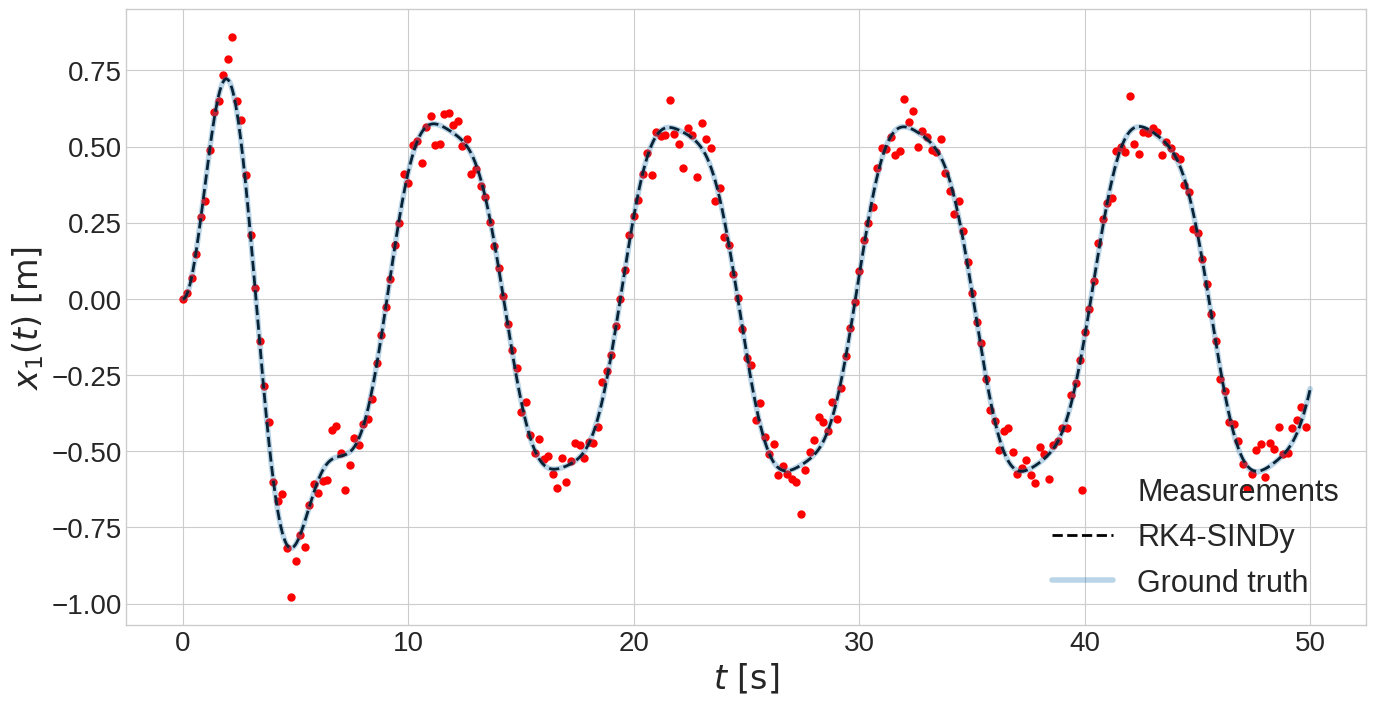

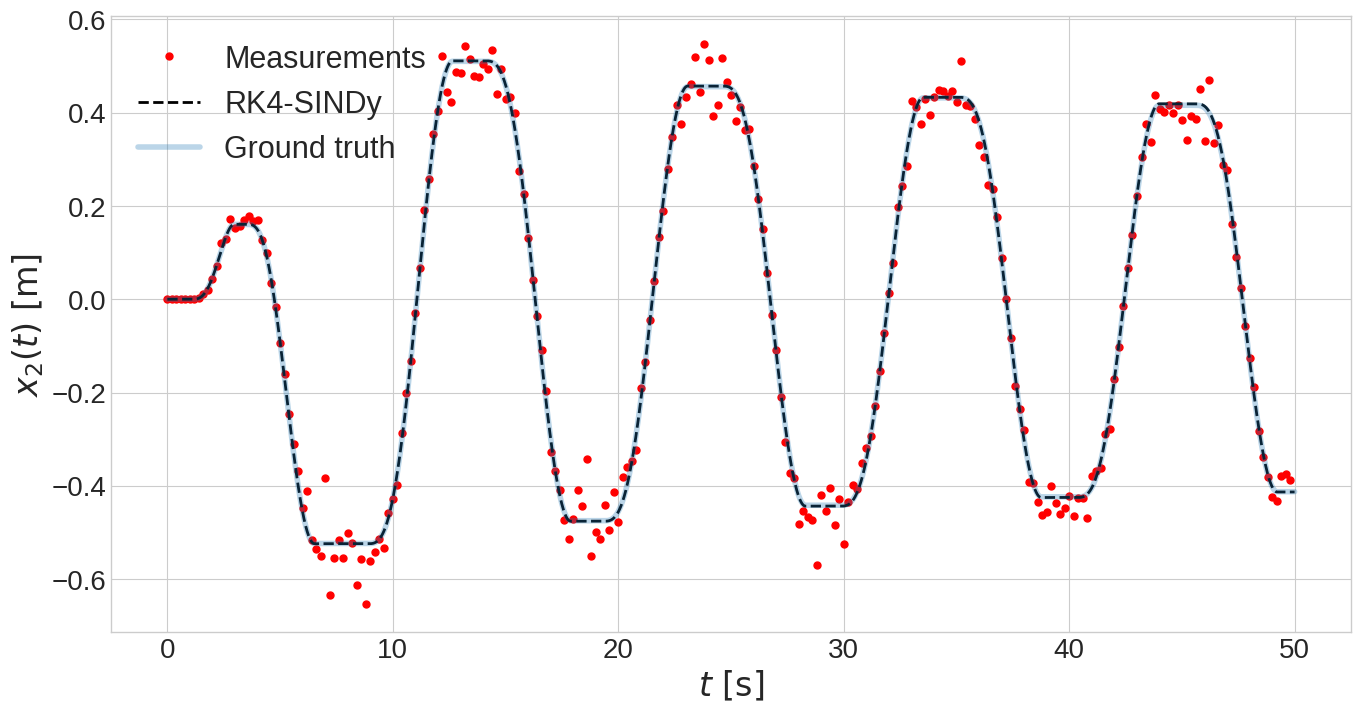

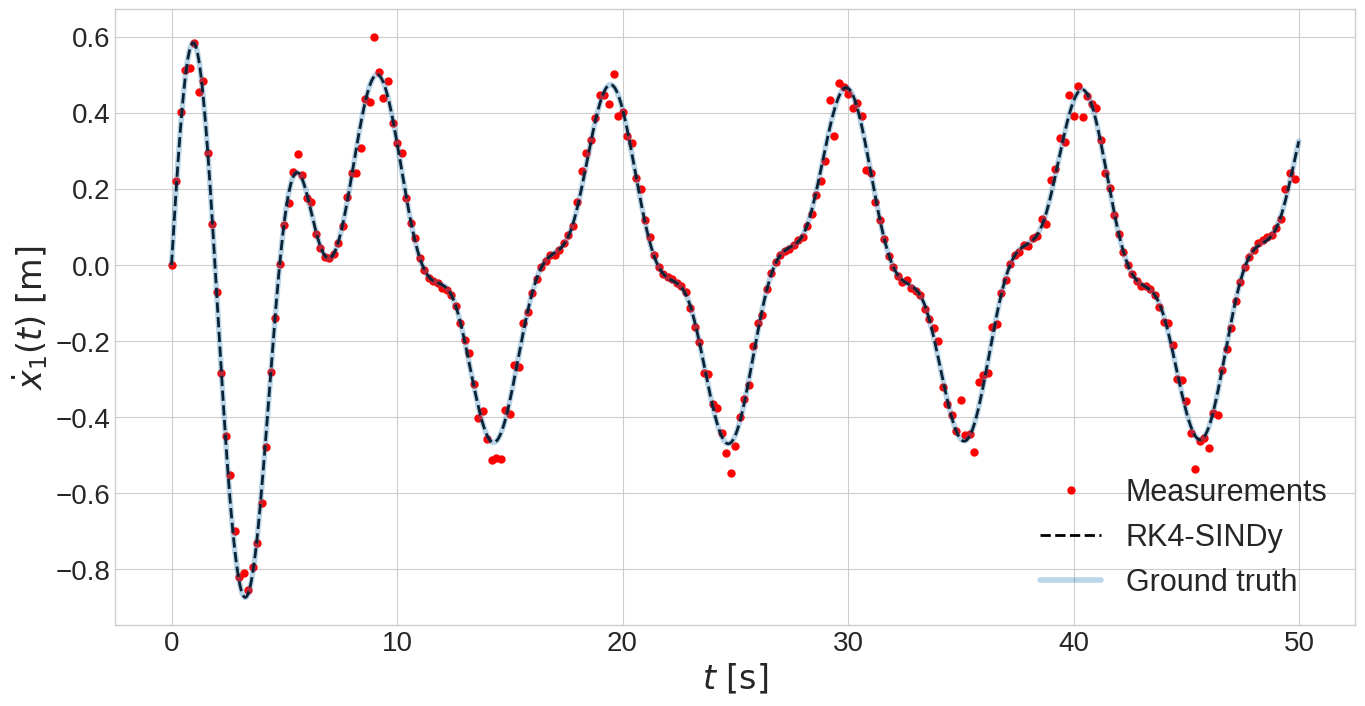

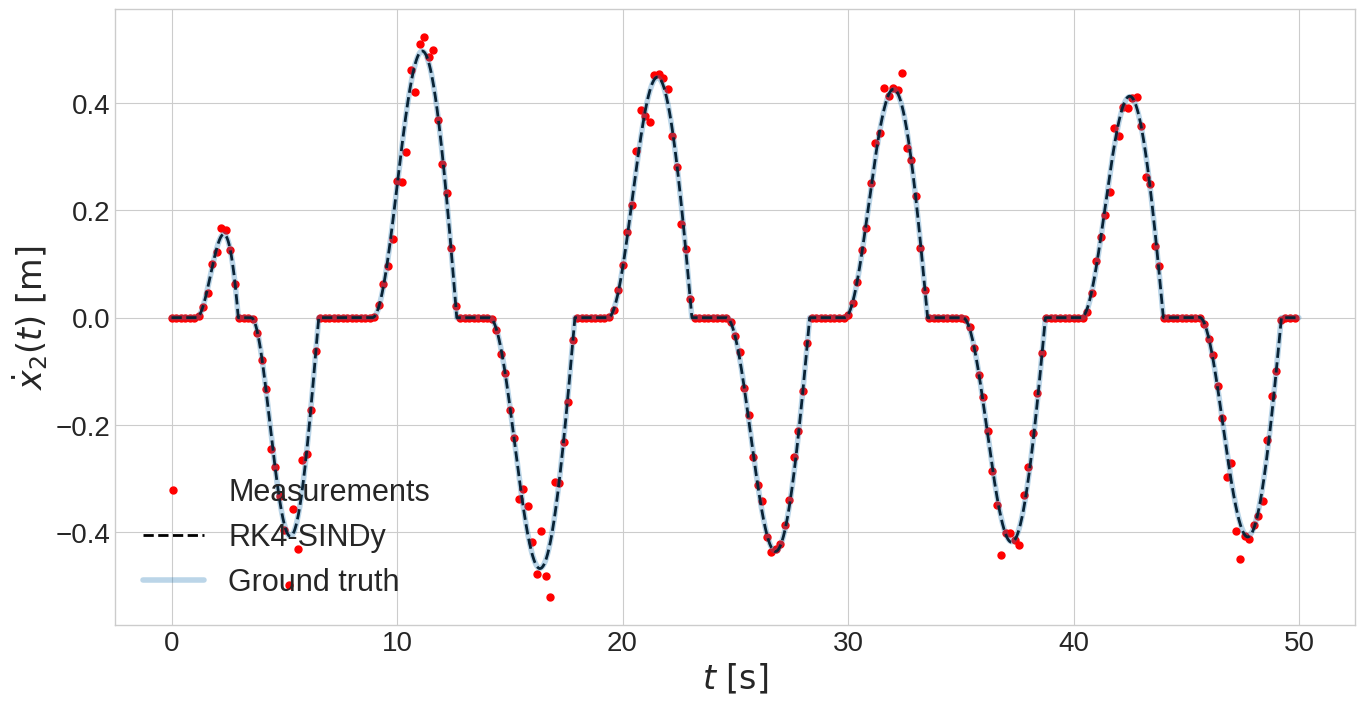

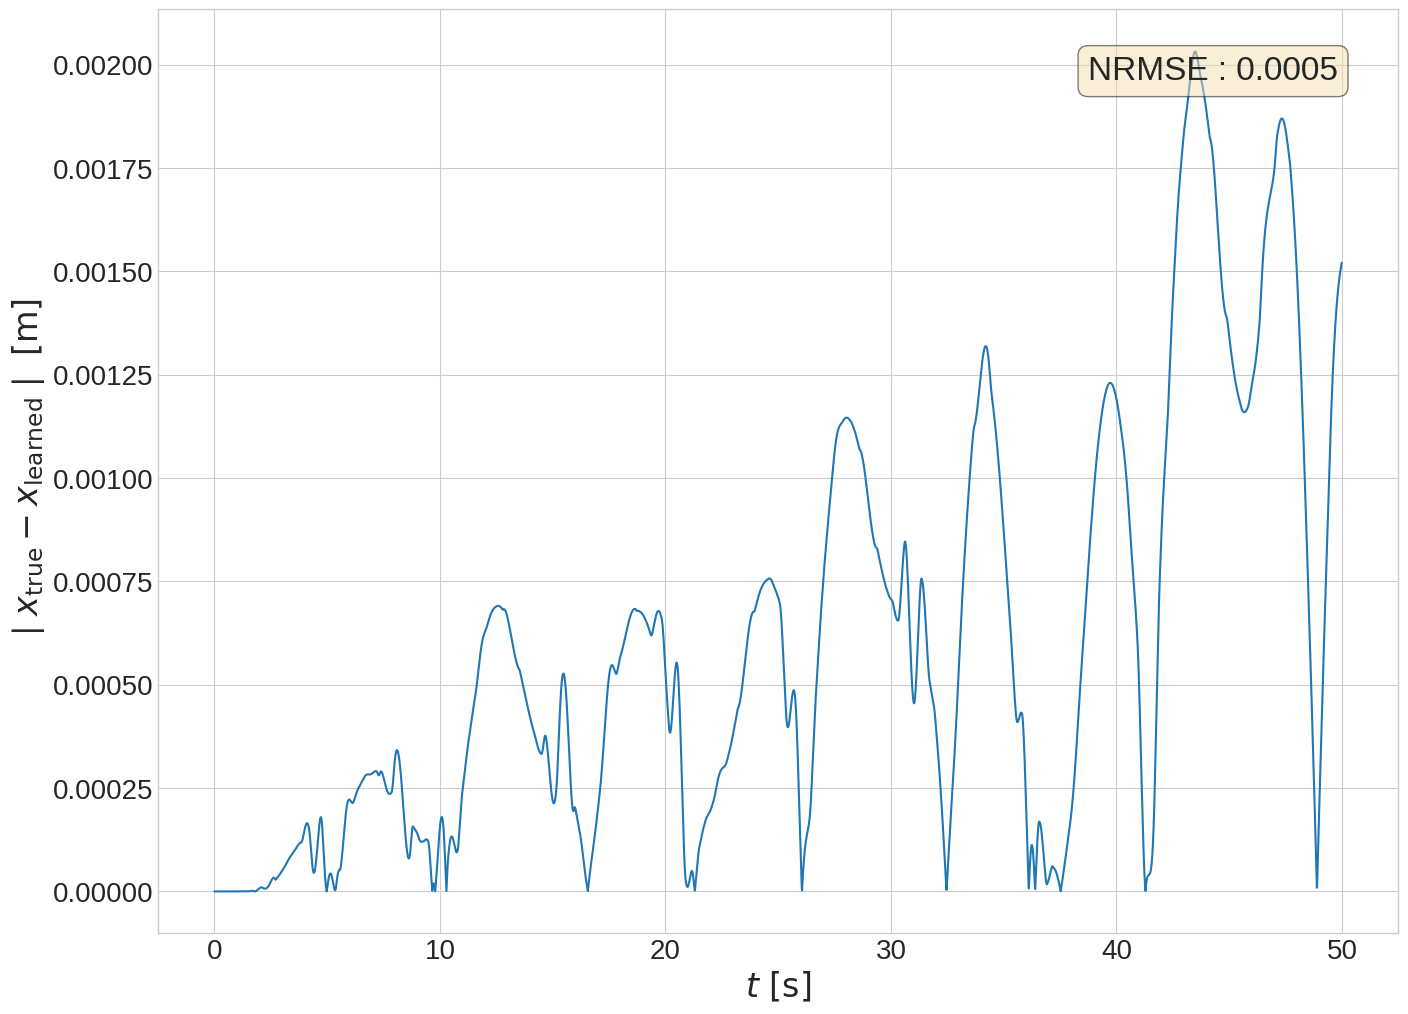

In [8]:
# Generate data to be plotted
sol_learnt = solve_ivp(lambda t, x: learnt_model(x, t, learnt_coeffs, Params), [ts[0], ts[-1]], Params.x0, t_eval=ts,)
x_learnt = np.transpose(sol_learnt.y)

# learnt_points = np.zeros_like(x)
# learnt_points[0] = Params.x0

# for k, t_ in enumerate(ts[1:], start=1):
#     learnt_points[k] = rk4th_onestep(learnt_model, learnt_points[k-1], t_, learnt_coeffs, Params)

Params.nrmse = np.sqrt(((x_denoised - x_learnt) ** 2).sum(axis=0) / x_learnt.shape[0]) / (x_denoised.max(axis=0) - x_denoised.min(axis=0))
print(f"NRMSE: {Params.nrmse}")
# Params.nrmse_2 = np.sqrt(((x_denoised - x_learnt) ** 2).sum(axis=0) / learnt_points.shape[0]) / (x_denoised.max(axis=0) - x_denoised.min(axis=0))
# print(f"NRMSE: {Params.nrmse_2}")

parent_dir = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\Results\\Paper"
child_dir = os.path.join(parent_dir, '1')

if False:
    # Directories setup
    setup_directories(child_dir)

    # Save hyperparameters, coefficients and loss
    store_results(Params, loss_track, learnt_coeffs, parent_dir, child_dir)

y_labels = (r"$x_1(t) \, \, \mathrm{[m]}$",
            r"$x_2(t) \, \, \mathrm{[m]}$",
            r"$\dot{x}_1(t) \, \, \mathrm{[m]}$",
            r"$\dot{x}_2(t) \, \, \mathrm{[m]}$")

for c, label in enumerate(y_labels):
    plot_results(ts, x_denoised[:, c], x[:, c], x_learnt[:, c], child_dir, y_label=label, save_flag=Params.save_analysis)

# for c, t in enumerate(('d', 'v')):
#     plot_results(ts, x_denoised[:, c], x[:, c], learnt_points[:, c], child_dir, type_flag=t, save_flag=Params.save_analysis)

plot_error(ts, x_denoised, x_learnt, Params.nrmse, child_dir, type_flag='d', save_flag=Params.save_analysis)

In [9]:
fsize = 11
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

In [10]:
# Generate data to be plotted
sol_learnt_2 = solve_ivp(lambda t, x: learnt_model(x, t, learnt_coeffs, Params), [ts[0], ts[-1]], Params.x0, t_eval=ts,)
x_learnt_2 = np.transpose(sol_learnt_2.y)

In [12]:
cm = 1/2.54
_, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(16*cm,16*cm), sharex=True)

ax1.plot(ts, x_learnt_2[:, 0], "k--", linewidth=1, label='RK4-SINDy - With event condition')
ax1.plot(ts, x_learnt[:, 0], "k-.", linewidth=1, alpha=0.5, label='RK4-SINDy - Without event condition')
ax1.plot(ts, x_denoised[:, 0], linewidth=1.5, alpha=0.3, label='Ground Truth')
# ax1.plot(ts[::100], x[::100, 0], "ro", markersize=2, label='Measurements')
ax2.plot(ts, x_learnt_2[:, 1], "k--", linewidth=1, label='RK4-SINDy - With event condition')
ax2.plot(ts, x_learnt[:, 1], "k-.", linewidth=1, alpha=0.5, label='RK4-SINDy - Without event condition')
ax2.plot(ts, x_denoised[:, 1], linewidth=1.5, alpha=0.3, label='Ground Truth')
# ax2.plot(ts[::100], x[::100, 1], "ro", markersize=2, linewidth=4, label='Measurements')
ax3.plot(ts, x_learnt_2[:, 2], "k--", linewidth=1, label='RK4-SINDy - With event condition')
ax3.plot(ts, x_learnt[:, 2], "k-.", linewidth=1, alpha=0.5, label='RK4-SINDy - Without event condition')
ax3.plot(ts, x_denoised[:, 2], linewidth=1.5, alpha=0.3, label='Ground Truth')
# ax3.plot(ts[::100], x[::100, 2], "ro", markersize=2, label='Measurements')
ax4.plot(ts, x_learnt_2[:, 3], "k--", linewidth=1, label='RK4-SINDy - With event condition')
ax4.plot(ts, x_learnt[:, 3], "k-.", linewidth=1, alpha=0.5, label='RK4-SINDy - Without event condition')
ax4.plot(ts, x_denoised[:, 3], linewidth=1.5, alpha=0.3, label='Ground Truth')
# ax4.plot(ts[::100], x[::100, 3], "ro", markersize=2, linewidth=4, label='Measurements')

plt.xlabel("$t$ [s]")
ax1.set_ylabel("$x_1(t)$ [m]")
ax2.set_ylabel("$x_2(t)$ [m]")
ax3.set_ylabel("$\dot{x}_1(t)$ [m/s]")
ax4.set_ylabel("$\dot{x}_2(t)$ [m/s]")


ax4.set_xticks(np.arange(0, 51, 10), np.arange(0, 51, 10))
ax1.set_yticks(np.arange(-2, 2.1, 1), np.arange(-2, 2.1, 1))
ax2.set_yticks(np.arange(-2.5, 2.6, 1), np.arange(-2.5, 2.6, 1))
ax3.set_yticks(np.arange(-1.0, 1.1, 0.5), np.arange(-1.0, 1.1, 0.5))
ax4.set_yticks(np.arange(-2, 2.1, 1),np.arange(-2, 2.1, 1))

ax1.set_ylim((-2, 2))
ax2.set_ylim((-2.5, 2.5))
ax3.set_ylim((-1, 1))
ax4.set_ylim((-2, 2))
# ax2.set_ylim((-0.05, 0.05))
ax4.set_xlim((0, 50))
# plt.legend(fontsize=20, bbox_to_anchor=(1., 5.1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 5.4), ncols=1, fontsize=11)#, handlelength =0.8, columnspacing=0.5, handletextpad=0.5)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax3.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
ax3.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax4.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../c2d32ca4ff25585485f6633e7f715d26.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../c2d32ca4ff25585485f6633e7f715d26.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on c2d32ca4ff25585485f6633e7f715d26.log.




<Figure size 1889.76x1889.76 with 4 Axes>